# Mercado Libre Data Challenge

### Importar módulos necesarios

In [3]:
import requests
import json
import pandas as pd
import numpy as np
from pandas import json_normalize
import time

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns

## Obtener token de acceso

In [5]:
client_id = "8782676683401387"
client_secret = "ZVZtn7SyembB8liDi1aU3JYd6ONgg2sX"
redirect_uri = "https://localhost:3000"

# Replace with the appropriate Mercado Libre site ID for your region
site_id = "MLM"

# URL for Mercado Libre's OAuth 2.0 authorization endpoint
auth_url = f"https://auth.mercadolibre.com.mx/authorization?response_type=code&client_id={client_id}&redirect_uri={redirect_uri}&site_id={site_id}"

In [6]:
# Redirect the user to the authorization URL
print(f"Visit the following URL to authorize the application:\n{auth_url}")

# After user authorization, obtain the authorization code from the redirected URL
authorization_code = input("Enter the authorization code from the redirected URL: ")

# URL for Mercado Libre's OAuth 2.0 token endpoint
token_url = "https://api.mercadolibre.com/oauth/token"

# Request access token using the authorization code
token_data = {
    "grant_type": "authorization_code",
    "client_id": client_id,
    "client_secret": client_secret,
    "redirect_uri": redirect_uri,
    "code": authorization_code
}

token_response = requests.post(token_url, data=token_data)
access_token = token_response.json().get("access_token")


print(f"Access Token: {access_token}")

Visit the following URL to authorize the application:
https://auth.mercadolibre.com.mx/authorization?response_type=code&client_id=8782676683401387&redirect_uri=https://localhost:3000&site_id=MLM


Enter the authorization code from the redirected URL:  TG-65a4c7ed5aee590001f8a1f0-1583124477


Access Token: APP_USR-8782676683401387-011501-fed94d4f2ef5378964f2ed4ff2824c7c-1583124477


## Elegir categoría de interés 

In [103]:
# Elegí la categoría "Electrónica, Audio y Video" en MX
category_id = site_id+"1000"

## Obtener lista de sellers en la categoría

- Me interesa obtener la mayor cantidad posible de datos, pero no sé cuántos hay disponibles. 
- Voy a iterar sobre 'offset' hasta que la API arroje un error para saber con cuántos datos cuento.

In [11]:
%%time
limit = 50  
offset = 0
all_items = []

while True:
    url = f"https://api.mercadolibre.com/sites/{site_id}/search?category={category_id}&access_token={access_token}&offset={offset}&limit={limit}"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        items = data.get("results", [])
        #seller_id = items.get("seller", []).get("id","Unknown")

        if not items:
            break
        
        # Adjuntar a lista de todos los items
        all_items.extend(items)

        # Aumentar el offset
        offset += limit-1
    else:
        print(f"Error: {response.status_code} - {response.text}")
        break

print(f"Total items in category: {len(all_items)}")


Error: 403 - {"message":"the requested offset is higher than the allowed for public users. Maximum allowed is 4000","error":"forbidden","status":403,"cause":[]}
Total items in category: 4038
CPU times: user 3.39 s, sys: 55 ms, total: 3.44 s
Wall time: 17.5 s


- Tengo acceso solamente a los primeros 4050 items en la categoría. 
- Voy a analizar a los sellers de esos 4050 items, que probablemente serán menos de 4050.

## Obtener datos de reputación del comprador

In [14]:
%%time

sellers_data = []

for item in all_items:
        seller = item.get("seller", {})
        seller_id = item.get("seller", {}).get("id", "")
        if seller_id:
            seller_details_url = f"https://api.mercadolibre.com/users/{seller_id}/?access_token={access_token}"
            seller_details_response = requests.get(seller_details_url)

            if seller_details_response.status_code == 200:
                seller_details = seller_details_response.json()
                
                seller_level = seller_details.get("seller_reputation", {}).get("level_id", "Unknown")
                seller_status = seller_details.get("seller_reputation", {}).get("power_seller_status", "Unknown")
                seller_transactions_period = seller_details.get("seller_reputation", {}).get("transactions", {}).get("period", "Unknown")
                seller_transactions_total = seller_details.get("seller_reputation", {}).get("transactions", {}).get("total", "Unknown")
                seller_metrics = seller_details.get("seller_reputation", {}).get("metrics", "Unknown")
                seller_transactions = seller_details.get("seller_reputation", {}).get("transactions", "Unknown")
                
                sellers_data.append({
                    "seller": seller,
                    "seller_id": seller_id,
                    "level": seller_level,
                    "status": seller_status,
                    "transactions_period": seller_transactions_period,
                    "transactions_total": seller_transactions_total,
                    "metrics": seller_metrics,
                    "transactions_general": seller_transactions
            })
                
              ##  print(f"""Seller ID: {seller_id}, 
              ##      Level_id: {seller_level}, 
              ##      Status: {seller_status}, 
              ##      Transactions: {seller_transactions_total}, 
              ##      Transactions period: {seller_transactions_period},
              ##      Metrics: {seller_metrics},
              ##      Transactions_general: {seller_transactions}""")
            else:
                print(f"Error fetching details for Seller ID {seller_id}. Status Code: {seller_details_response.status_code}")


CPU times: user 2min 31s, sys: 1.58 s, total: 2min 32s
Wall time: 4min 9s


## Obtener datos de reviews de productos

In [16]:
%%time

reviews_data = []
redo_items=[]

for item in all_items:
        item_id = item.get("id", {})
        #item_cat_id = item.get("catalog_product_id", {})
        if item_id:
            item_reviews_url = f"https://api.mercadolibre.com/reviews/item/{item_id}/?access_token={access_token}"
            item_reviews_response = requests.get(item_reviews_url)

            if item_reviews_response.status_code == 200:
                item_details = item_reviews_response.json()
                
                rating_average = item_details.get("rating_average", "Unknown")
               
                reviews_data.append({
                    "id": item_id,
                    "rating_average": rating_average,
                })
                time.sleep(0.15)
            else:
                if item_reviews_response.status_code == 429:
                    if "Retry-After" in response.headers:
                        retry_after_seconds = int(response.headers["Retry-After"])
                        print(f"Received 429. Waiting for {retry_after_seconds} seconds.")
                        time.sleep(retry_after_seconds)
                        response = requests.get(item_reviews_url)
                    else:
                        print(f"Error en item {item_id}.429.Recibidos:{len(reviews_data)} de {len(all_items)}")
                        redo_items.append(item_id)
                        time.sleep(20)
    
    
                else:
                    print(f"Error fetching details for item ID {item_id}. Status Code: {item_reviews_response.status_code}")


Error en item MLM1967139153.429.Recibidos:165 de 4038
Error en item MLM1851173858.429.Recibidos:221 de 4038
Error en item MLM2583753734.429.Recibidos:280 de 4038
Error en item MLM1988863937.429.Recibidos:328 de 4038
Error en item MLM1886601825.429.Recibidos:391 de 4038
Error en item MLM1428035750.429.Recibidos:455 de 4038
Error en item MLM1983830129.429.Recibidos:523 de 4038
Error en item MLM2281973428.429.Recibidos:583 de 4038
Error en item MLM2289044116.429.Recibidos:644 de 4038
Error en item MLM1665876679.429.Recibidos:713 de 4038
Error en item MLM1322619962.429.Recibidos:762 de 4038
Error en item MLM1933342455.429.Recibidos:829 de 4038
Error en item MLM1764743578.429.Recibidos:869 de 4038
Error en item MLM1948764277.429.Recibidos:927 de 4038
Error en item MLM1958445283.429.Recibidos:972 de 4038
Error en item MLM2765927884.429.Recibidos:1024 de 4038
Error en item MLM1955477903.429.Recibidos:1075 de 4038
Error en item MLM2739898274.429.Recibidos:1125 de 4038
Error en item MLM15345465

In [17]:
%%time

for item in redo_items:
        item_id = item
        #item_cat_id = item.get("catalog_product_id", {})
        if item_id:
            item_reviews_url = f"https://api.mercadolibre.com/reviews/item/{item_id}/?access_token={access_token}"
            item_reviews_response = requests.get(item_reviews_url)

            if item_reviews_response.status_code == 200:
                item_details = item_reviews_response.json()
                
                rating_average = item_details.get("rating_average", "Unknown")
               
                reviews_data.append({
                    "id": item_id,
                    "rating_average": rating_average,
                })
                time.sleep(0.15)
            else:
                if item_reviews_response.status_code == 429:
                    if "Retry-After" in response.headers:
                        retry_after_seconds = int(response.headers["Retry-After"])
                        print(f"Received 429. Waiting for {retry_after_seconds} seconds.")
                        time.sleep(retry_after_seconds)
                        response = requests.get(item_reviews_url)
                    else:
                        print(f"Error en item {item_id}.429.Recibidos:{len(reviews_data)} de {len(all_items)}")
                        time.sleep(20)
    
    
                else:
                    print(f"Error fetching details for item ID {item_id}. Status Code: {item_reviews_response.status_code}")


Error en item MLM1851173858.429.Recibidos:3975 de 4038
Error en item MLM2385696454.429.Recibidos:4022 de 4038
CPU times: user 2.57 s, sys: 16.7 ms, total: 2.59 s
Wall time: 56.4 s


## Convertir listas en DataFrame

In [19]:
df_sellers = pd.DataFrame(sellers_data) 
df_sellers.head(1)

,seller,seller_id,level,status,transactions_period,transactions_total,metrics,transactions_general
0,"{'id': 535252227, 'nickname': 'FULAME'}",535252227,5_green,platinum,historic,705451,Unknown,"{'period': 'historic', 'total': 705451}"


In [20]:
df_sellers.seller.dtype

dtype('O')

In [21]:
df_reviews = pd.DataFrame(reviews_data)
df_reviews['id']=df_reviews['id'].astype(str)
df_reviews.head(1)

,id,rating_average
0,MLM1365534355,4.7


In [22]:
df_items = pd.DataFrame(all_items)
df_items['id']=df_items['id'].astype('str')
df_items['seller_id']=df_items['seller'].str['id']
df_items.head(1)

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,attributes,variations_data,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,seller_id
0,MLM1365534355,1hora Mini Bocina Portátil Bluetooth Inalámbri...,new,774048-MLM70963883413_082023,None,gold_special,https://articulo.mercadolibre.com.mx/MLM-13655...,buy_it_now,MLM,MLM59800,...,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",{'174097331810': {'thumbnail': 'http://http2.m...,"{'quantity': 24, 'amount': 9, 'rate': 45.03, '...",None,False,None,[],None,NaN,535252227


In [23]:
df_sellers.seller.dtype


dtype('O')

In [24]:
df_items.seller_id.head()

0    535252227
1    671689030
2    399621798
3    742974626
4    739812272
Name: seller_id, dtype: int64

## Unir DataFrames para tener más features por seller

In [26]:
df_items_rating = df_items.merge(df_reviews, how='left', on='id')


In [27]:
df_items_sellers = df_items_rating.merge(df_sellers, how='left', on='seller_id')

In [28]:
df_items_sellers.head()

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,differential_pricing,seller_id,rating_average,seller_y,level,status,transactions_period,transactions_total,metrics,transactions_general
0,MLM1365534355,1hora Mini Bocina Portátil Bluetooth Inalámbri...,new,774048-MLM70963883413_082023,None,gold_special,https://articulo.mercadolibre.com.mx/MLM-13655...,buy_it_now,MLM,MLM59800,...,NaN,535252227,4.7,"{'id': 535252227, 'nickname': 'FULAME'}",5_green,platinum,historic,705451,Unknown,"{'period': 'historic', 'total': 705451}"
1,MLM1365534355,1hora Mini Bocina Portátil Bluetooth Inalámbri...,new,774048-MLM70963883413_082023,None,gold_special,https://articulo.mercadolibre.com.mx/MLM-13655...,buy_it_now,MLM,MLM59800,...,NaN,535252227,4.7,"{'id': 535252227, 'nickname': 'FULAME'}",5_green,platinum,historic,705451,Unknown,"{'period': 'historic', 'total': 705451}"
2,MLM1365534355,1hora Mini Bocina Portátil Bluetooth Inalámbri...,new,774048-MLM70963883413_082023,None,gold_special,https://articulo.mercadolibre.com.mx/MLM-13655...,buy_it_now,MLM,MLM59800,...,NaN,535252227,4.7,"{'id': 535252227, 'nickname': 'FULAME'}",5_green,platinum,historic,705451,Unknown,"{'period': 'historic', 'total': 705451}"
3,MLM1365534355,1hora Mini Bocina Portátil Bluetooth Inalámbri...,new,774048-MLM70963883413_082023,None,gold_special,https://articulo.mercadolibre.com.mx/MLM-13655...,buy_it_now,MLM,MLM59800,...,NaN,535252227,4.7,"{'id': 535252227, 'nickname': 'FULAME'}",5_green,platinum,historic,705451,Unknown,"{'period': 'historic', 'total': 705451}"
4,MLM1365534355,1hora Mini Bocina Portátil Bluetooth Inalámbri...,new,774048-MLM70963883413_082023,None,gold_special,https://articulo.mercadolibre.com.mx/MLM-13655...,buy_it_now,MLM,MLM59800,...,NaN,535252227,4.7,"{'id': 535252227, 'nickname': 'FULAME'}",5_green,platinum,historic,705451,Unknown,"{'period': 'historic', 'total': 705451}"


In [29]:
df_items_sellers.columns

Index(['id', 'title', 'condition', 'thumbnail_id', 'catalog_product_id',
       'listing_type_id', 'permalink', 'buying_mode', 'site_id', 'category_id',
       'domain_id', 'thumbnail', 'currency_id', 'order_backend', 'price',
       'original_price', 'sale_price', 'available_quantity',
       'official_store_id', 'official_store_name', 'use_thumbnail_id',
       'accepts_mercadopago', 'variation_filters', 'shipping', 'stop_time',
       'seller_x', 'attributes', 'variations_data', 'installments',
       'winner_item_id', 'catalog_listing', 'discounts', 'promotions',
       'inventory_id', 'differential_pricing', 'seller_id', 'rating_average',
       'seller_y', 'level', 'status', 'transactions_period',
       'transactions_total', 'metrics', 'transactions_general'],
      dtype='object')

In [30]:
pd.pandas.set_option('display.max_columns', None)
df_items_sellers.head(1)

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,official_store_name,use_thumbnail_id,accepts_mercadopago,variation_filters,shipping,stop_time,seller_x,attributes,variations_data,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,seller_id,rating_average,seller_y,level,status,transactions_period,transactions_total,metrics,transactions_general
0,MLM1365534355,1hora Mini Bocina Portátil Bluetooth Inalámbri...,new,774048-MLM70963883413_082023,None,gold_special,https://articulo.mercadolibre.com.mx/MLM-13655...,buy_it_now,MLM,MLM59800,MLM-SPEAKERS,http://http2.mlstatic.com/D_774048-MLM70963883...,MXN,1,148.99,259.99,None,5000,3502.0,1HORA,True,True,[COLOR],"{'store_pick_up': False, 'free_shipping': Fals...",2042-01-09T04:00:00.000Z,"{'id': 535252227, 'nickname': 'FULAME'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",{'174097331810': {'thumbnail': 'http://http2.m...,"{'quantity': 24, 'amount': 9, 'rate': 45.03, '...",None,False,None,[],None,NaN,535252227,4.7,"{'id': 535252227, 'nickname': 'FULAME'}",5_green,platinum,historic,705451,Unknown,"{'period': 'historic', 'total': 705451}"


## Análisis exploratorio inicial
En esta etapa, me interesa entender qué variables a nivel item tengo y decidir cómo me conviene agregarlas a nivel seller.

### Condition: %
- Respecto a la condición del producto, los valores posibles son "new", "used" y "not specified". 
- Me interesa conocer la distribución de estos resultados por seller. 
- Idealmente, calcularía el % de new (#new/#veces que aparece el seller en mi data), así como el de used. 
- Voy a programarlo así en caso de que después se usen otros datos. 
- En estos datos en particular, todos los artículos son nuevos, por lo cual esta variable no será informativa. Esto pasa con algunas otras variables más adelante, como 'buying_mode'.

In [33]:
df_items_sellers.condition.value_counts()

condition
new    56604
Name: count, dtype: int64

### Listing_type_id: %

In [35]:
df_items_sellers.listing_type_id.value_counts()

listing_type_id
gold_pro        32758
gold_special    23846
Name: count, dtype: int64

### Buying mode: %

In [37]:
df_items_sellers.buying_mode.value_counts()

buying_mode
buy_it_now    56604
Name: count, dtype: int64

### Price: mean, min, max

In [39]:
df_items_sellers.price.value_counts()

price
399.00    1363
99.00     1313
299.00     976
899.00     771
109.00     609
          ... 
154.96       1
650.00       1
435.89       1
497.17       1
198.82       1
Name: count, Length: 2616, dtype: int64

### Original price: mean difference between original and current price

In [41]:
df_items_sellers['delta_price']=df_items_sellers['price']-df_items_sellers['original_price']

### Sale price: 0 if None, 1 if any

In [43]:
df_items_sellers['sale_price_any'] = df_items_sellers['sale_price'].notna().astype(int)

### Available quantity: mean, min, max

### Official store id: 0 if None, 1 if any

In [46]:
df_items_sellers['official_store_any'] = df_items_sellers['official_store_id'].notna().astype(int)

### Accepts mercadopago: 0 if False, 1 if True

### Shipping: 
- Shipping es un json con información valiosa:
    - store_pick_up: True/False
    - free_shipping: True/False
 
 Para este ejercicio, solo tomaré en cuenta 'store_pick_up' y 'free_shipping', pues son las más claras. 

In [49]:
df_items_sellers = (pd.concat([df_items_sellers.drop(['shipping'], axis=1), 
                               json_normalize(df_items_sellers['shipping'])], axis=1))

In [50]:
df_items_sellers = df_items_sellers.rename({'mode':'mode_'}, axis='columns')

In [51]:
df_items_sellers = df_items_sellers.drop({'logistic_type', 'mode_','tags', 'benefits', 'promise'}, axis='columns')

### Catalog listing: 0 if False, 1 if True

### Discounts: 0 if None, 1 if any

In [54]:
df_items_sellers['discounts_any'] = df_items_sellers['discounts'].notna().astype(int)

### Promotions: 0 if None, 1 if any

In [56]:
df_items_sellers['promotions_any'] = df_items_sellers['promotions'].notna().astype(int)

### Diff pricing: %

In [58]:
df_items_sellers.differential_pricing.value_counts()

differential_pricing
{'id': 35713375}    15470
{'id': 35713377}    13288
{'id': 35713376}     2766
Name: count, dtype: int64

### Variation filters: 0 if None, 1 if any

In [60]:
df_items_sellers['variation_filters_any'] = df_items_sellers['variation_filters'].notna().astype(int)

## Agregar a nivel seller

In [62]:
df_items_sellers.columns

Index(['id', 'title', 'condition', 'thumbnail_id', 'catalog_product_id',
       'listing_type_id', 'permalink', 'buying_mode', 'site_id', 'category_id',
       'domain_id', 'thumbnail', 'currency_id', 'order_backend', 'price',
       'original_price', 'sale_price', 'available_quantity',
       'official_store_id', 'official_store_name', 'use_thumbnail_id',
       'accepts_mercadopago', 'variation_filters', 'stop_time', 'seller_x',
       'attributes', 'variations_data', 'installments', 'winner_item_id',
       'catalog_listing', 'discounts', 'promotions', 'inventory_id',
       'differential_pricing', 'seller_id', 'rating_average', 'seller_y',
       'level', 'status', 'transactions_period', 'transactions_total',
       'metrics', 'transactions_general', 'delta_price', 'sale_price_any',
       'official_store_any', 'store_pick_up', 'free_shipping', 'discounts_any',
       'promotions_any', 'variation_filters_any'],
      dtype='object')

In [63]:
aggregations = {
    'condition': lambda x: x.value_counts().idxmax(), 
    'listing_type_id': lambda x: x.value_counts().idxmax(),
    'buying_mode': lambda x: x.value_counts().idxmax(),  
    'price': ['min', 'max', 'mean', 'sum'],
    'delta_price': ['min', 'max'],
    'sale_price_any': 'mean',
    'available_quantity': ['min', 'max', 'mean'],
    'official_store_any': 'mean',
    'accepts_mercadopago': 'mean',
    'store_pick_up':'mean',
    'free_shipping': 'mean',
    'catalog_listing': 'mean',
    'discounts_any':'mean',
    'promotions_any':'mean',
    'differential_pricing': lambda x: x.value_counts(dropna=False).idxmax(), 
    'variation_filters_any': 'mean',
    'level': 'first',
    'status': 'first',
    'transactions_period': 'first', 
    'transactions_total': 'first',
    'metrics': 'first',
   'transactions_general': 'first',
    'rating_average': 'mean'
}

In [64]:
keep_columns = ['condition', 'listing_type_id', 'buying_mode', 'price', 'delta_price',
           'sale_price_any', 'available_quantity', 'official_store_any', 'accepts_mercadopago',
           'store_pick_up', 'free_shipping', 'catalog_listing', 'discounts_any', 'promotions_any',
            'differential_pricing', 'variation_filters_any',
            'seller_id', 'level', 'status', 'transactions_period', 'transactions_total', 'metrics',
           'transactions_general', 'rating_average' ]

In [65]:
df = (
    df_items_sellers[keep_columns]
    .groupby('seller_id').agg(aggregations).reset_index()
)

In [66]:
df.columns = df.columns.map('_'.join).str.strip('_')

In [67]:
df.columns

Index(['seller_id', 'condition_<lambda>', 'listing_type_id_<lambda>',
       'buying_mode_<lambda>', 'price_min', 'price_max', 'price_mean',
       'price_sum', 'delta_price_min', 'delta_price_max',
       'sale_price_any_mean', 'available_quantity_min',
       'available_quantity_max', 'available_quantity_mean',
       'official_store_any_mean', 'accepts_mercadopago_mean',
       'store_pick_up_mean', 'free_shipping_mean', 'catalog_listing_mean',
       'discounts_any_mean', 'promotions_any_mean',
       'differential_pricing_<lambda>', 'variation_filters_any_mean',
       'level_first', 'status_first', 'transactions_period_first',
       'transactions_total_first', 'metrics_first',
       'transactions_general_first', 'rating_average_mean'],
      dtype='object')

In [68]:
df['differential_pricing']=df['differential_pricing_<lambda>'].astype("str")
df['metrics']=df['metrics_first'].astype("str")
df['transactions_general']=df['transactions_general_first'].astype("str")

In [69]:
df['seller_level']= df['level_first'].map({'5_green': 5, '4_light_green': 4, '3_yellow':3, 
                                           '2_orange':2, '1_red':1})

In [70]:
df=df.drop('differential_pricing_<lambda>', axis='columns')
df=df.drop('metrics_first', axis='columns')
df=df.drop('transactions_general_first', axis='columns')
df=df.drop('level_first', axis='columns')

In [71]:
df=df.rename({'status_first':'seller_status'}, axis='columns')
df=df.rename({'price_sum':'total_money'}, axis='columns')
df=df.rename({'rating_average_mean':'rating_average'}, axis='columns')

## Análisis exploratorio a nivel seller

<Axes: xlabel='rating_average', ylabel='total_money'>

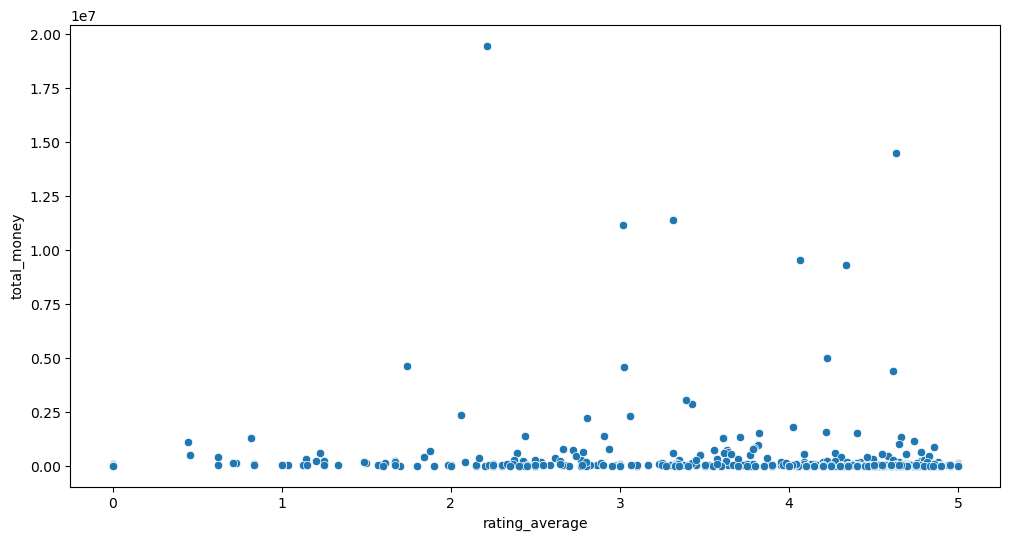

In [483]:
sns.scatterplot(data=df, x='rating_average', y='total_money')

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



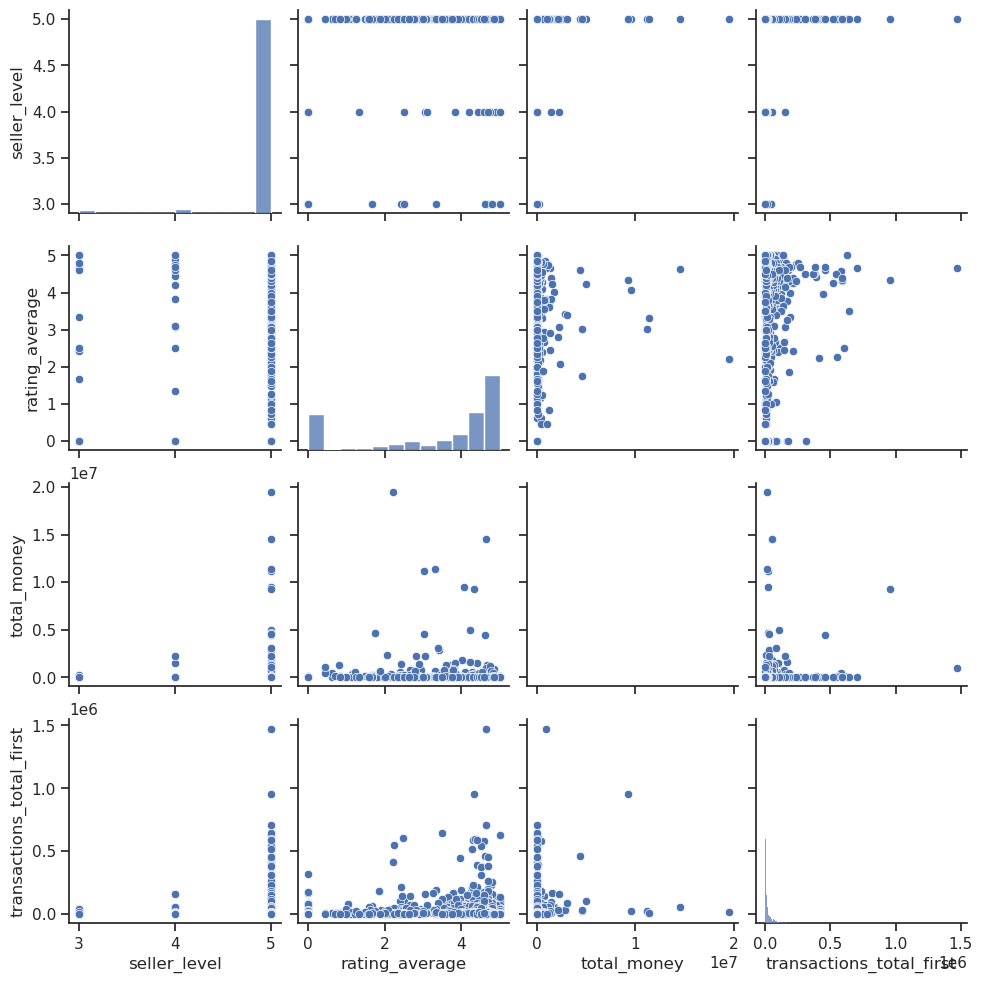

In [657]:
sns.set_theme(style="ticks")

sns.pairplot(df[['seller_level', 'seller_status', 'rating_average', 'total_money', 'transactions_total_first']]) 
plt.savefig("initial_exploration.png")

## Eliminar columnas sin variabilidad entre sellers
Estas columnas no serán informativas.

In [73]:
def quitar_columnas_constantes(df):
    return df.loc[:,df.nunique() > 1]

df_filtrado = quitar_columnas_constantes(df)

In [74]:
df_filtrado.columns

Index(['seller_id', 'listing_type_id_<lambda>', 'price_min', 'price_max',
       'price_mean', 'total_money', 'delta_price_min', 'delta_price_max',
       'available_quantity_min', 'available_quantity_max',
       'available_quantity_mean', 'official_store_any_mean',
       'free_shipping_mean', 'catalog_listing_mean',
       'variation_filters_any_mean', 'seller_status',
       'transactions_total_first', 'rating_average', 'differential_pricing',
       'transactions_general', 'seller_level'],
      dtype='object')

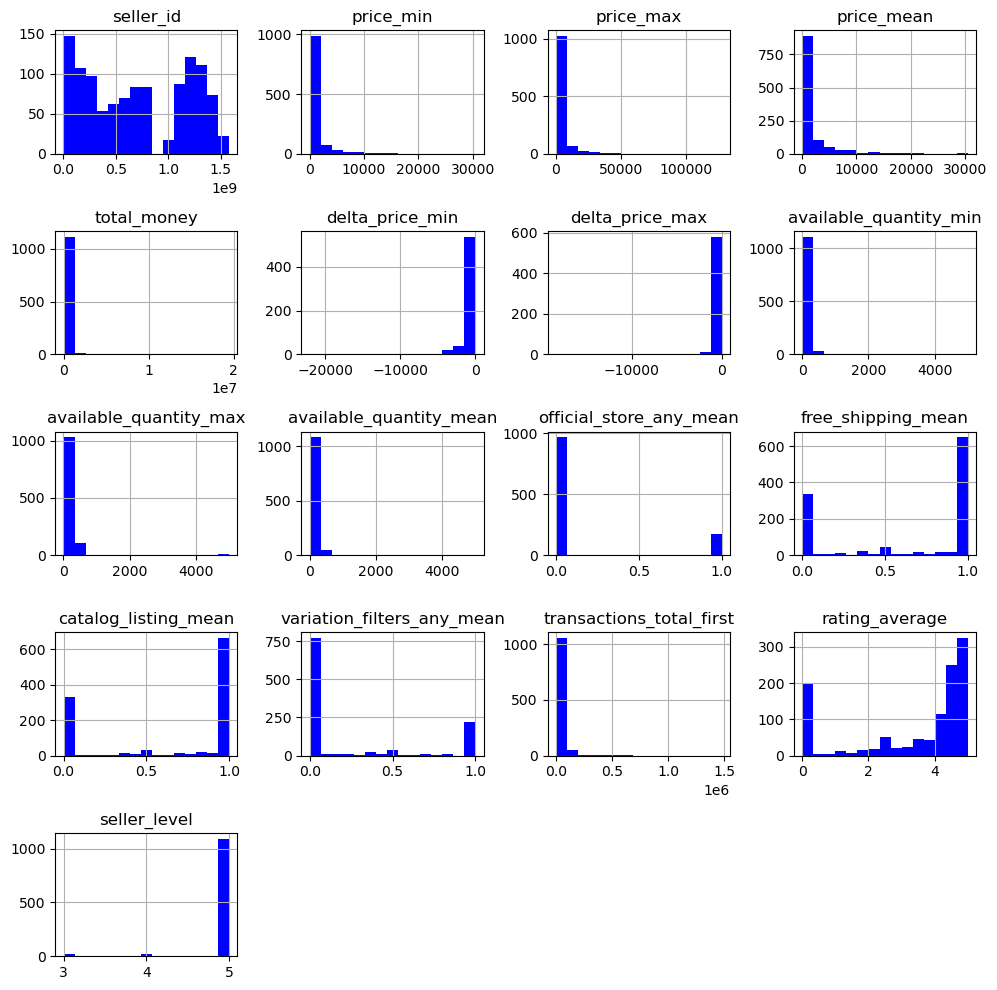

In [75]:
df_filtrado.hist(figsize=(10, 10),  bins=15, color='blue')
plt.tight_layout()
plt.show()

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



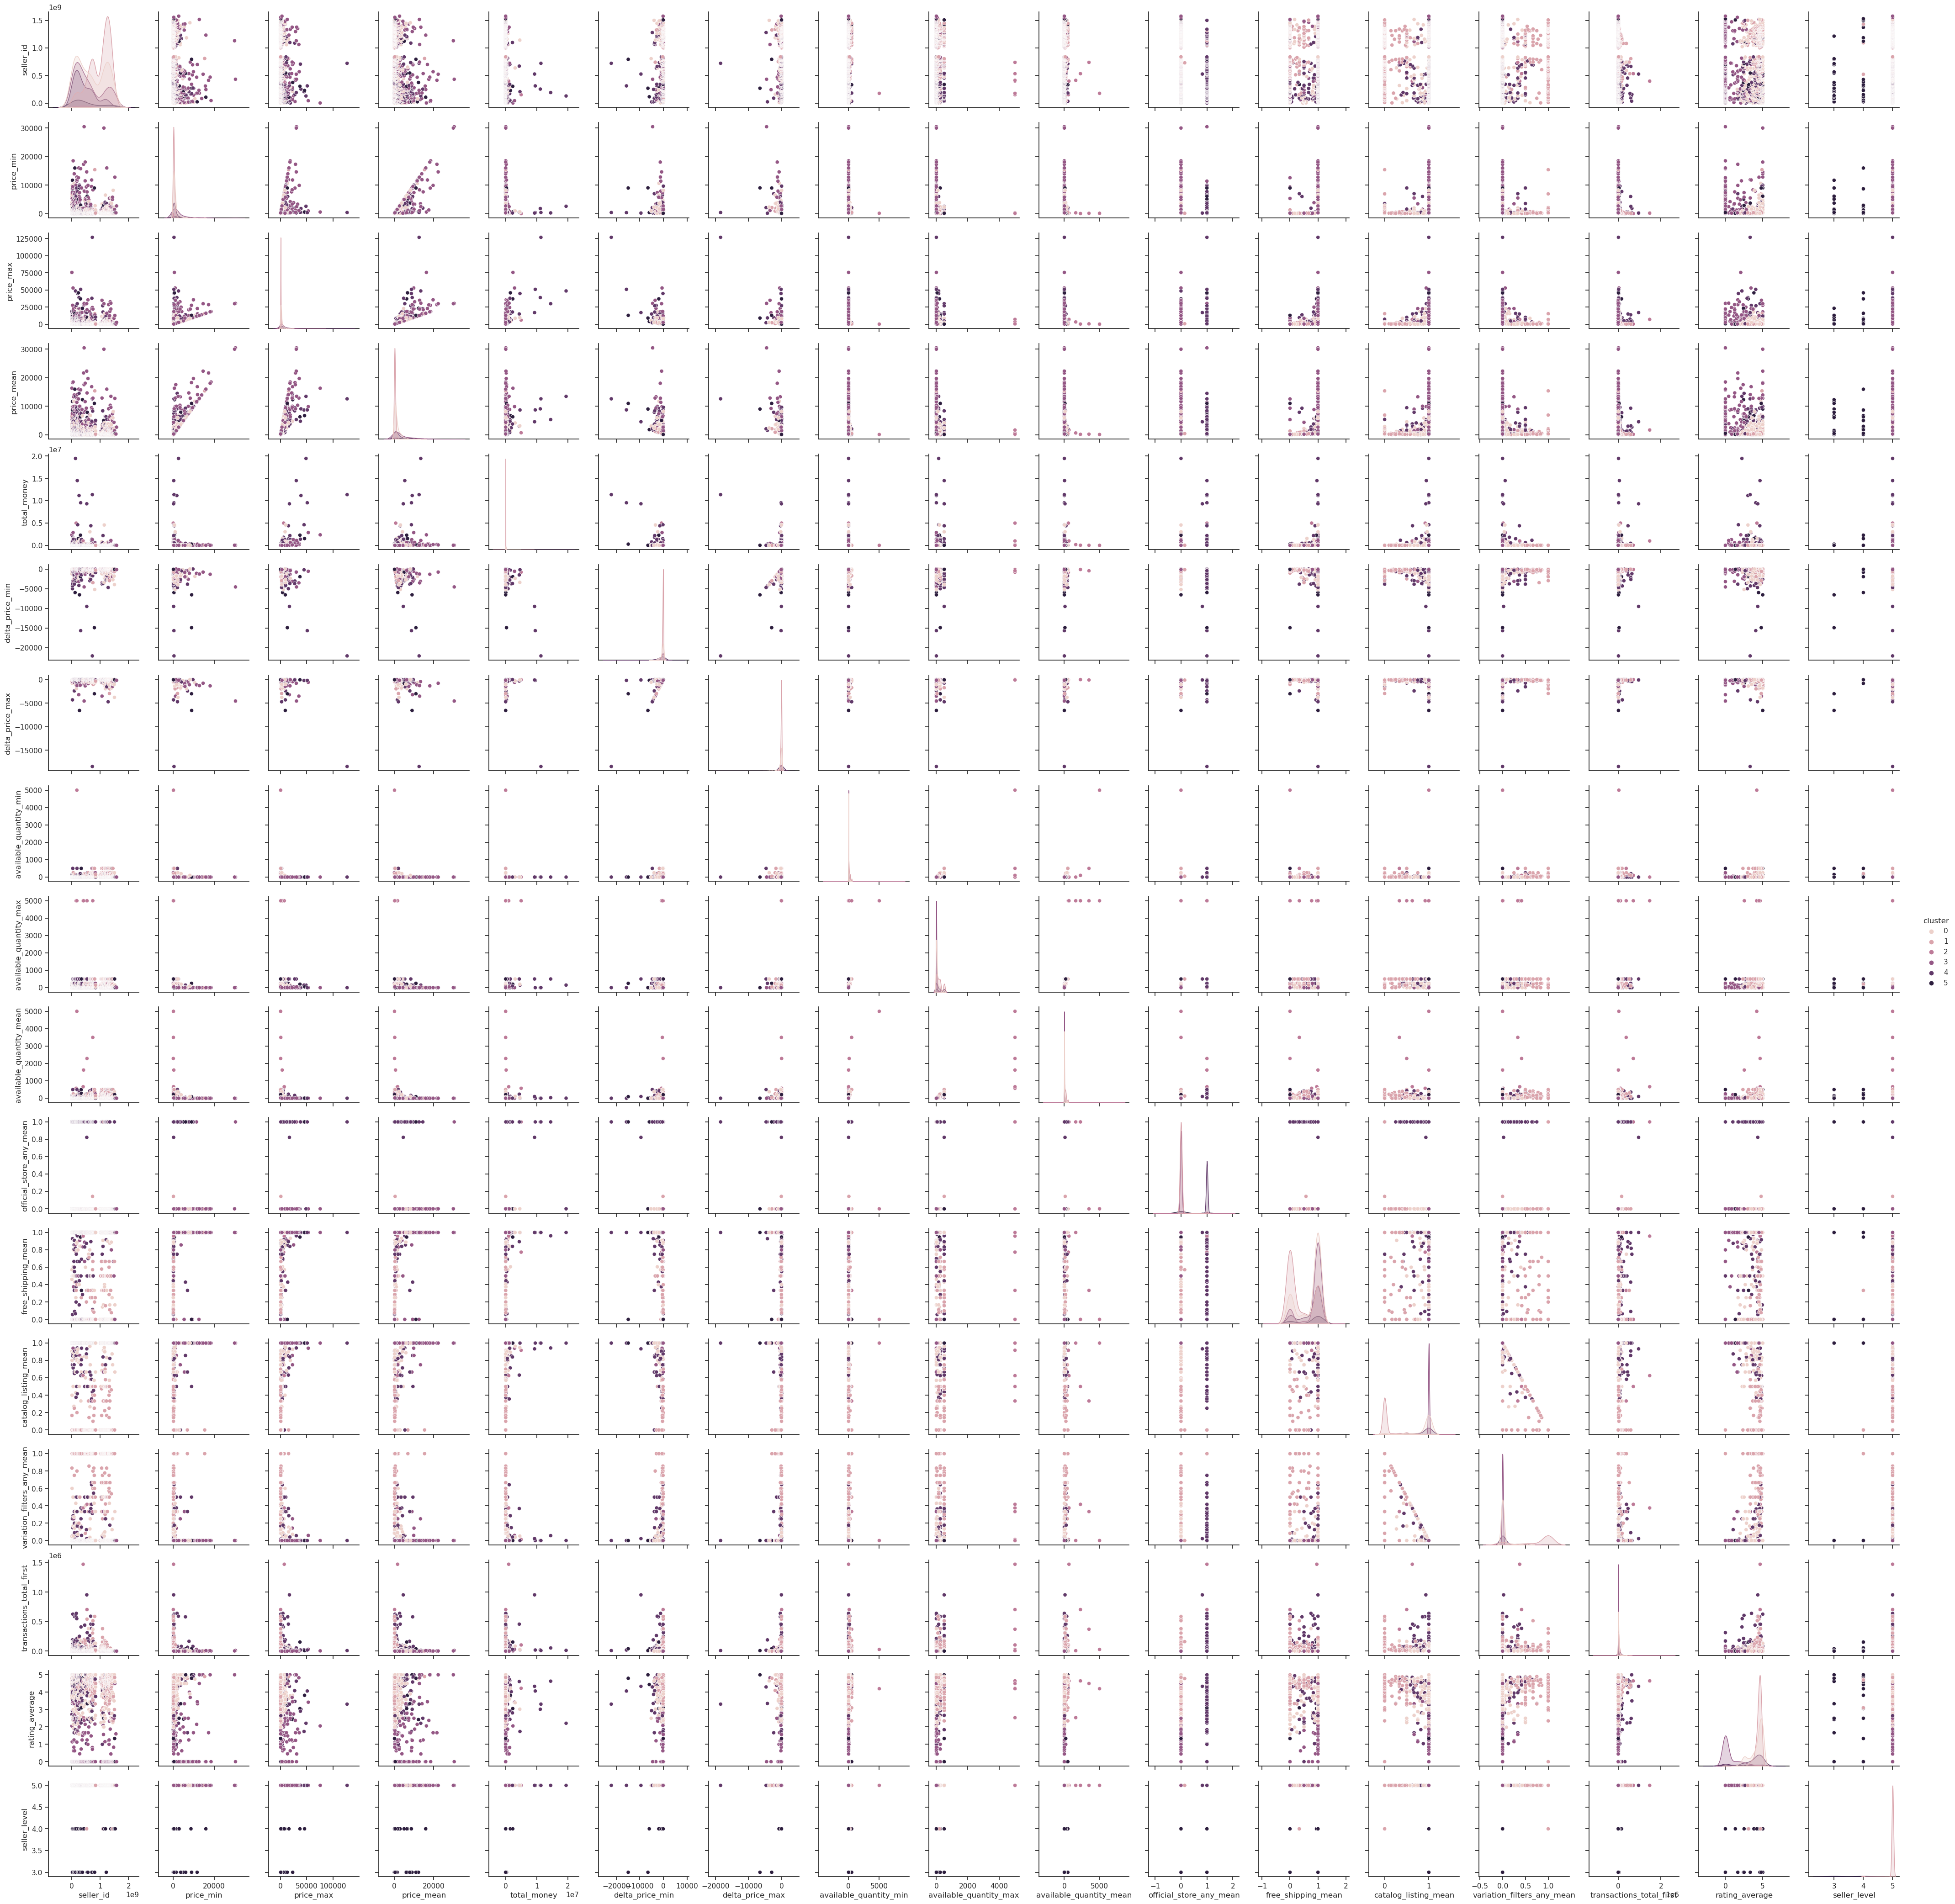

In [491]:
sns.set_theme(style="ticks")

sns.pairplot(df_filtrado)

## Estandarizar variables numéricas

In [661]:
columns_clustering = [
    #'listing_type_id_<lambda>', 'price_mean',
    'total_money', #'price_min', 'price_max',
    #'available_quantity_mean',
    #'available_quantity_max', #'available_quantity_min',
    #'official_store_any_mean', 'free_shipping_mean', 'catalog_listing_mean',
    #'variation_filters_any_mean', 
    'seller_level', 'seller_status',
    'transactions_total_first', 
    #'differential_pricing', 
    'rating_average',
    #'delta_price_min', #'delta_price_max'
]

In [677]:
categorical_columns = [
    #'listing_type_id_<lambda>','differential_pricing',
    'seller_status'
]

In [679]:
df_clustering = df[columns_clustering]

In [681]:
numeric_columns = [col for col in columns_clustering if col not in categorical_columns]

In [682]:
numeric_transformer = StandardScaler()
df_numeric_scaled = numeric_transformer.fit_transform(df_clustering[numeric_columns])

In [685]:
categorical_transformer = OneHotEncoder(drop='first', sparse=False) 
df_categorical_encoded = categorical_transformer.fit_transform(df_clustering[categorical_columns])

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [686]:
df_scaled = pd.DataFrame(
    data=np.concatenate([df_numeric_scaled, df_categorical_encoded], axis=1),
    columns=numeric_columns + list(categorical_transformer.get_feature_names_out(categorical_columns))
)

## Cluster usando k-means

In [690]:
df_scaled.head()

,total_money,seller_level,transactions_total_first,rating_average,seller_status_platinum,seller_status_silver,seller_status_None
0,-0.074496,0.191776,-0.159499,0.262745,1.0,0.0,0.0
1,-0.136913,0.191776,-0.263317,0.779816,1.0,0.0,0.0
2,-0.136176,0.191776,-0.061767,0.890923,1.0,0.0,0.0
3,2.189488,0.191776,-0.343329,-0.743265,1.0,0.0,0.0
4,0.570985,0.191776,-0.027955,-0.374895,1.0,0.0,0.0


In [692]:
missing_values = df_scaled.isnull().sum()
print(missing_values)

total_money                 0
seller_level                0
transactions_total_first    0
rating_average              0
seller_status_platinum      0
seller_status_silver        0
seller_status_None          0
dtype: int64


In [694]:
#df_scaled['delta_price_min']= df_scaled['delta_price_min'].fillna(0)
#df_scaled['delta_price_max']= df_scaled['delta_price_max'].fillna(0)

In [696]:
#df_scaled['rating_average']= df_scaled['rating_average'].fillna(0)

### Elegir número de clusters

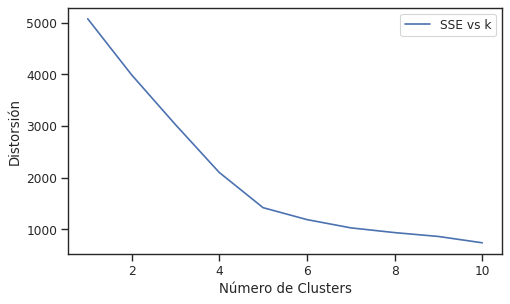

In [699]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, tol=1e-04, random_state=2024, n_init=10)
    km.fit(df_scaled)
    distortions.append(km.inertia_)
plt.figure(figsize=(7, 4), dpi=80)
plt.plot(range(1,11), distortions, label="SSE vs k")
plt.xlabel("Número de Clusters")
plt.ylabel("Distorsión")
plt.legend(loc='upper right')
plt.show()

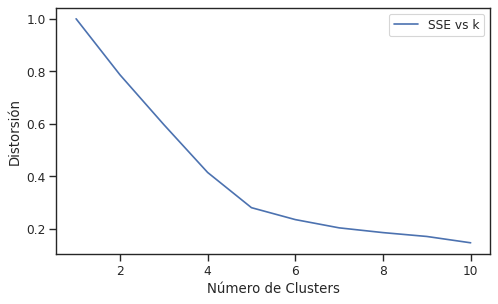

In [700]:
km = KMeans(n_clusters=1, init='k-means++', max_iter=300, tol=1e-04, random_state=1, n_init=10)
km.fit(df_scaled)
SSE_total = km.inertia_
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, tol=1e-04, random_state=2024, n_init=10)
    km.fit(df_scaled)
    distortions.append(km.inertia_/SSE_total)

plt.figure(figsize=(7, 4), dpi=80)
plt.plot(range(1,11), distortions, label="SSE vs k")
plt.xlabel("Número de Clusters")
plt.ylabel("Distorsión")
plt.legend(loc='upper right')
plt.show()

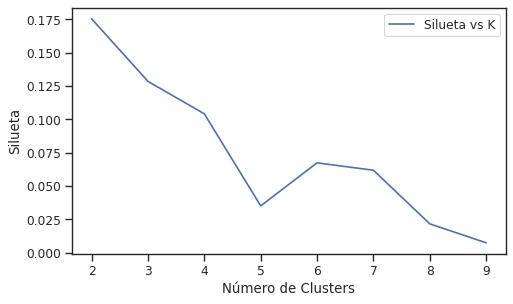

In [701]:
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
siluetas = []
for i in range(2, 10):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, tol=1e-04, random_state=2024, n_init=10)
    km.fit(df_scaled)
    silueta = metrics.silhouette_score(X,km.labels_,metric="euclidean")
    siluetas.append(silueta)

plt.figure(figsize=(7, 4), dpi=80)
plt.plot(range(2,10), siluetas, label="Silueta vs K")
plt.xlabel("Número de Clusters")
plt.ylabel("Silueta")
plt.legend(loc='upper right')
plt.show()


In [799]:
%%time
k = 6
kmeans = KMeans(n_clusters=k, random_state=20240, init='k-means++', n_init=10)
df_filtrado['cluster'] = kmeans.fit_predict(df_scaled)
df_scaled_cluster=df_scaled
df_scaled_cluster['cluster']=kmeans.fit_predict(df_scaled)

<timed exec>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CPU times: user 881 ms, sys: 12.7 ms, total: 893 ms
Wall time: 3.7 s


In [800]:
df_filtrado.cluster.value_counts()

cluster
4    548
1    261
0    255
2     45
5     23
3      5
Name: count, dtype: int64

## Analizar resultados

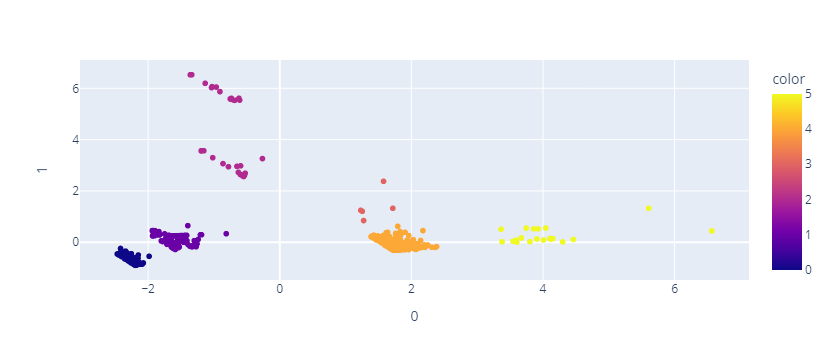

In [803]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


pca = PCA(n_components=0.99)
components = pca.fit_transform(df_scaled)

fig = px.scatter(components, x=0, y=1, color=df_scaled_cluster['cluster'])
fig.show()

In [804]:
df_filtrado.columns

Index(['seller_id', 'listing_type_id_<lambda>', 'price_min', 'price_max',
       'price_mean', 'total_money', 'delta_price_min', 'delta_price_max',
       'available_quantity_min', 'available_quantity_max',
       'available_quantity_mean', 'official_store_any_mean',
       'free_shipping_mean', 'catalog_listing_mean',
       'variation_filters_any_mean', 'seller_status',
       'transactions_total_first', 'rating_average', 'differential_pricing',
       'transactions_general', 'seller_level', 'cluster'],
      dtype='object')

In [805]:
df_plot=df_filtrado[['total_money', 
    'seller_level', 'seller_status',
    'transactions_total_first', 
    'rating_average', 'cluster']]

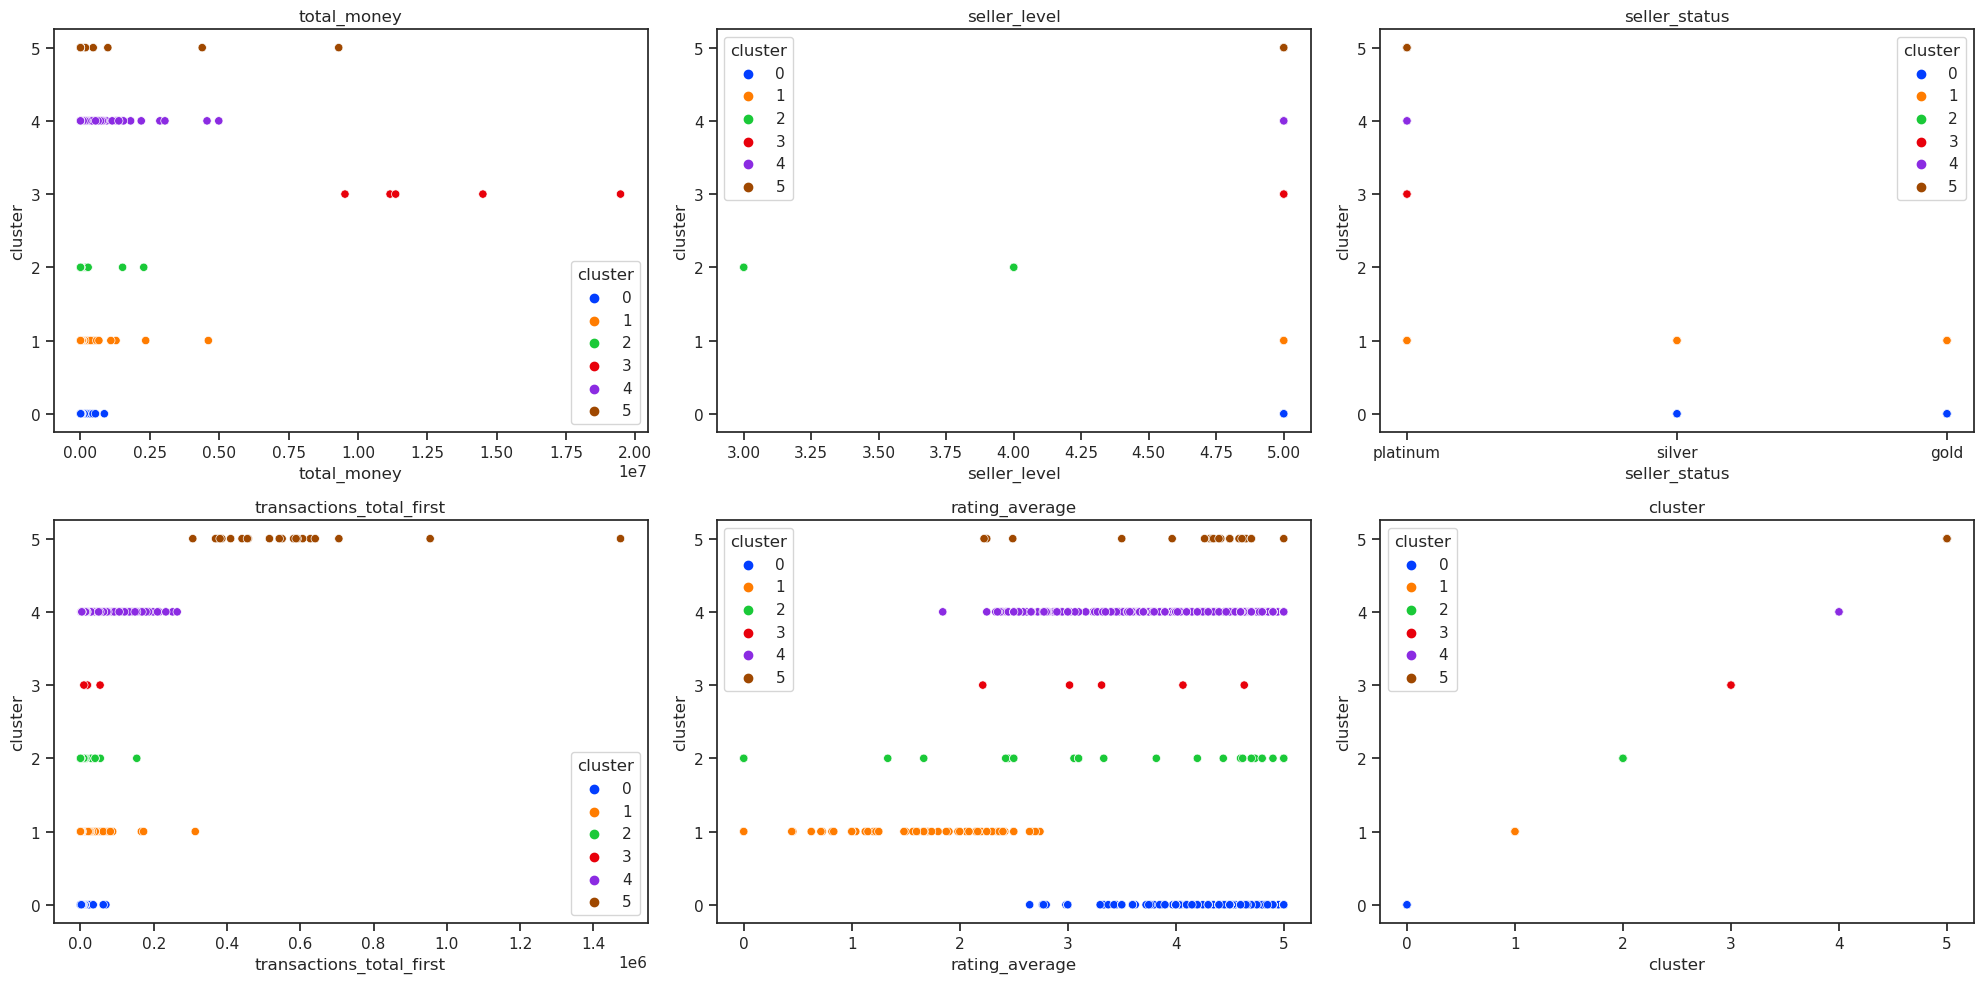

In [821]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
axes = axes.flatten()

for i, feature in enumerate(df_plot.columns):
    sns.scatterplot(data=df_plot,x=feature,y='cluster', ax=axes[i], hue='cluster', palette='bright')
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

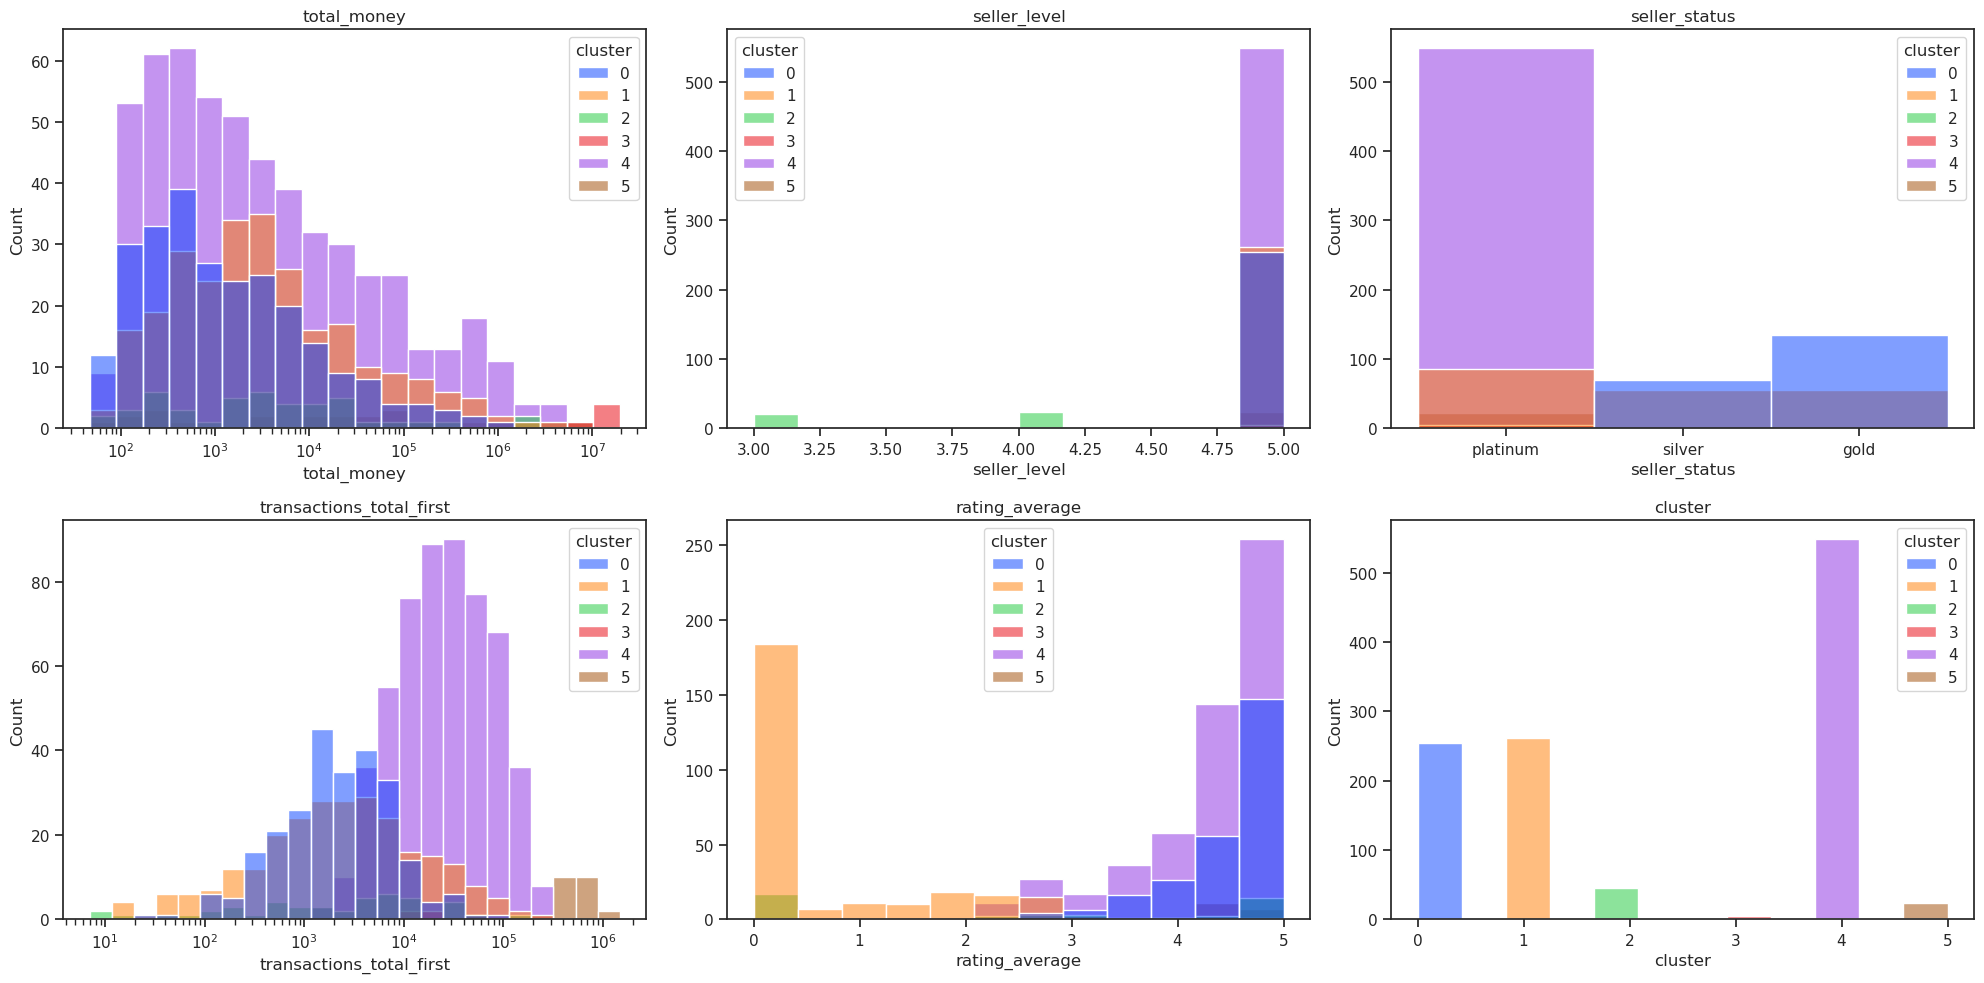

In [822]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
axes = axes.flatten()

for i, feature in enumerate(df_plot.columns):
    logscale=False
    if feature in ['price_min','price_max','price_mean','total_money', 
                   'available_quantity_min',
                  'available_quantity_max', 'available_quantity_mean', 
                   'transactions_total_first']: logscale=True
    sns.histplot(data=df_plot, x=feature, hue='cluster', palette='bright', ax=axes[i], log_scale=logscale)
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()


<Axes: xlabel='rating_average', ylabel='total_money'>

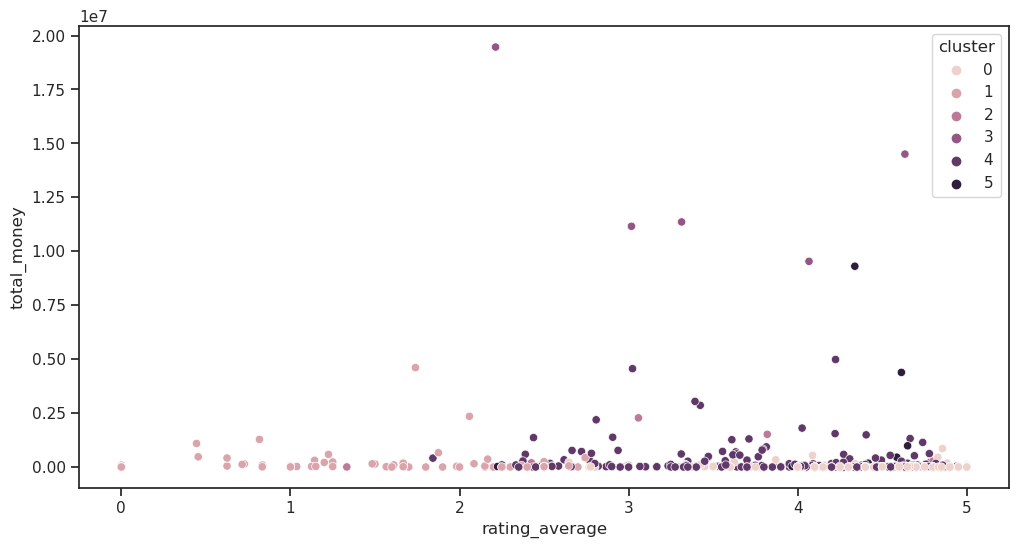

In [808]:
sns.scatterplot(data=df_filtrado, x='rating_average', y='total_money', hue='cluster')
#, size=None, style=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, legend='auto', ax=None, **kwargs)